#### Problem 1: Loading a FITS file

In [218]:
from astropy.io import fits
import os

def load_fits(filepath,ext=0):
    '''
    A function which requires the filepath to a FITS file as a string input and an optional extention which is an integer input, 0 as default and returns a tuple object containing the header and data at that extension
    
    Parameters
    ----------
    filepath: str
                Its the path to the FITS file which can be absolute or relative
    ext: int, optional
                It is an optional extension to the header data unit, default = 0
    
    Returns
    -------
    info
        A tuple object containing the header and data of the HDU at a given extension
        
    '''
    with fits.open(filepath) as hdu: # this is a context manager
        header,image = (hdu[ext].header,hdu[ext].data)
    return header,image
    

#### Problem 2: Data I/O


In [219]:
load_fits('Rband_antenna.fits');

In [232]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS

def implot(image,figsize=(15,13),
           cmap='gray_r',scale=0.5,colorbar=False,
           header=None,wcs=None,grid=None,**kwargs):
    
    '''
    Plot an image with an image input which returns the figure and axis of the plot
    
    Parameters
    ----------
    image: array-like
        The image data to plot
    figsize : tuple, optional
        The size of the plot figure in inches. Default is (15, 13).
    cmap : str, optional
        The colormap to use for the plot. Default is 'gray_r'.
    scale : float, optional
        The scale factor for the color limits. Default is 0.5.
    colorbar : bool, optional
        Whether to show a colorbar with the plot. Default is False.
    header : dict-like, optional
        The header of the FITS file containing the image data. Default is None.
    wcs : astropy.wcs.WCS, optional
        The WCS object for the image. Default is None.
    grid : bool, optional
        Whether to show a coordinate grid overlay. Default is None.
    **kwargs: dict, optional
        Additional keyword arguments, vmin and vmax to pass to the imshow() function.
        
    Returns
    -------
    fig : matplotlib.figure.Figure
          The figure object containing the image.
    ax : matplotlib.axes.Axes
         The axes object containing the image.
    
    '''
    if wcs:
        fig,ax = plt.subplots(figsize=figsize,subplot_kw={'projection':wcs})
        plt.xlabel('Right Ascension [hms]',fontsize=15)
        plt.ylabel('Declination [degrees]',fontsize=15)
    elif header is not None and wcs is None:
        wcs = WCS(header)
        fig,ax = plt.subplots(figsize=figsize,subplot_kw={'projection':wcs})
        plt.xlabel('Right Ascension [hms]',fontsize=15)
        plt.ylabel('Declination [degrees]',fontsize=15)
    else:
        fig,ax = plt.subplots(figsize=figsize)
        
    # Set mean and standard deviation
    mu = np.mean(image)
    sigma = np.std(image)
    
    # Set min and max value for brightness and contrast of the image
    vmin = kwargs.get('vmin',mu-scale*sigma)
    vmax = kwargs.get('vmax',mu+scale*sigma)
    
    # Display the image
    im = ax.imshow(image,origin='lower',cmap=cmap,vmin=vmin ,vmax=vmax)
    
    # Set tick parameters
    ax.tick_params(direction='in',length=7.5,width=1.5,labelsize=15)
    
    # Display the grid
    if grid == True:
        ax.coords.grid(color='gray', alpha=0.5, linestyle='solid')
    
    # Display the colorbar
    if colorbar == True:
        cbar = plt.colorbar(im, shrink=0.95)
    
    return (fig,ax)

(<Figure size 1500x1300 with 1 Axes>, <WCSAxes: >)

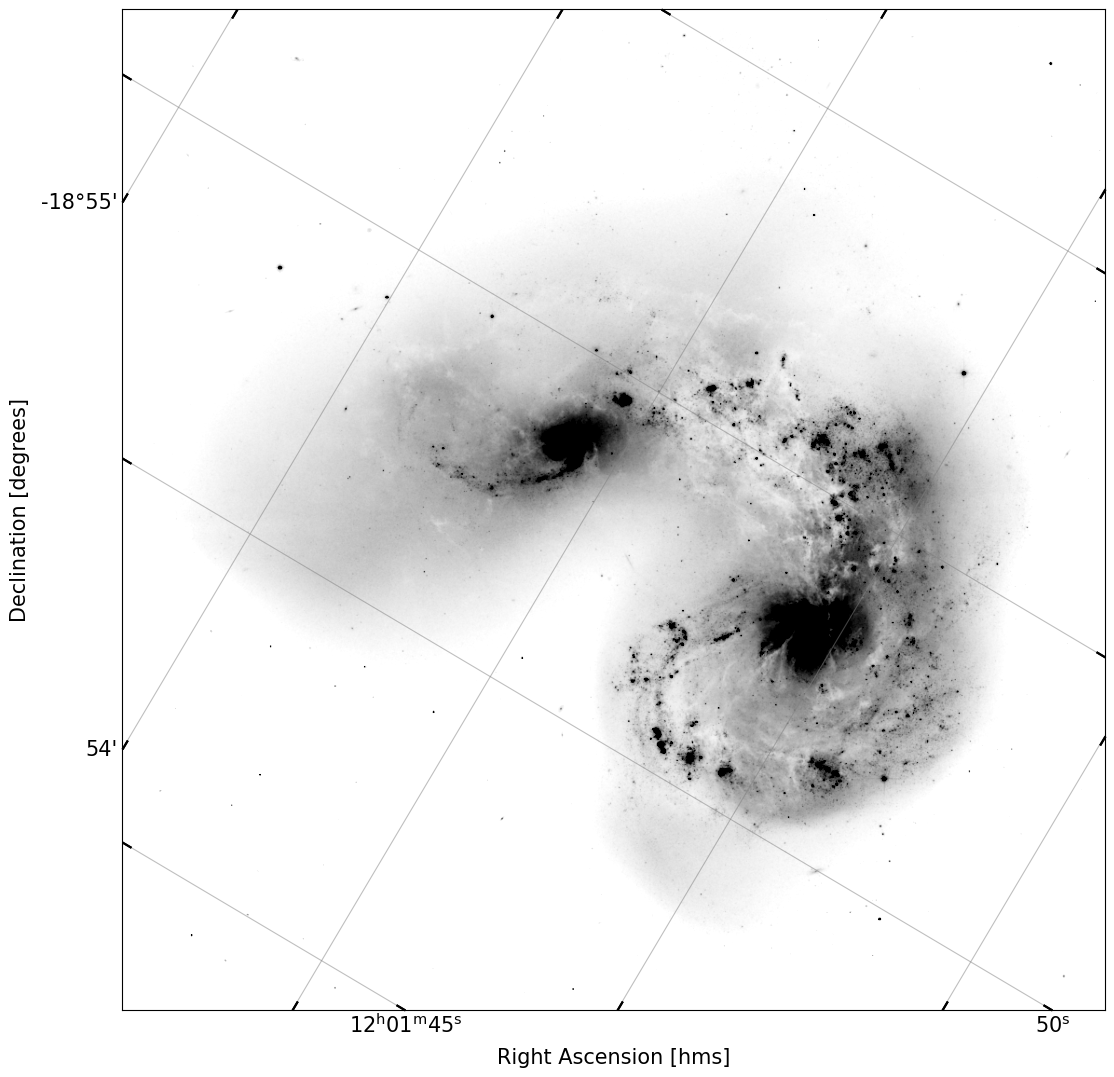

In [235]:
def strip_SIP(header):
    A_prefixes = [i for i in header.keys() if i.startswith('A_')]
    B_prefixes = [i for i in header.keys() if i.startswith('B_')]
    for a,b in zip(A_prefixes,B_prefixes):
        del header[a]
        del header[b]
    return header


info = load_fits('Rband_antenna.fits');
image = info[1]
new_header = strip_SIP(info[0])
wcs = WCS(new_header)

implot(image,header=new_header,vmin=mu-0.2*sigma,vmax=mu+3*sigma,grid=True)


#### Problem 3: Cutouts and Aperture Photometry and Flux Calibration

(<Figure size 1500x1300 with 1 Axes>, <WCSAxes: >)

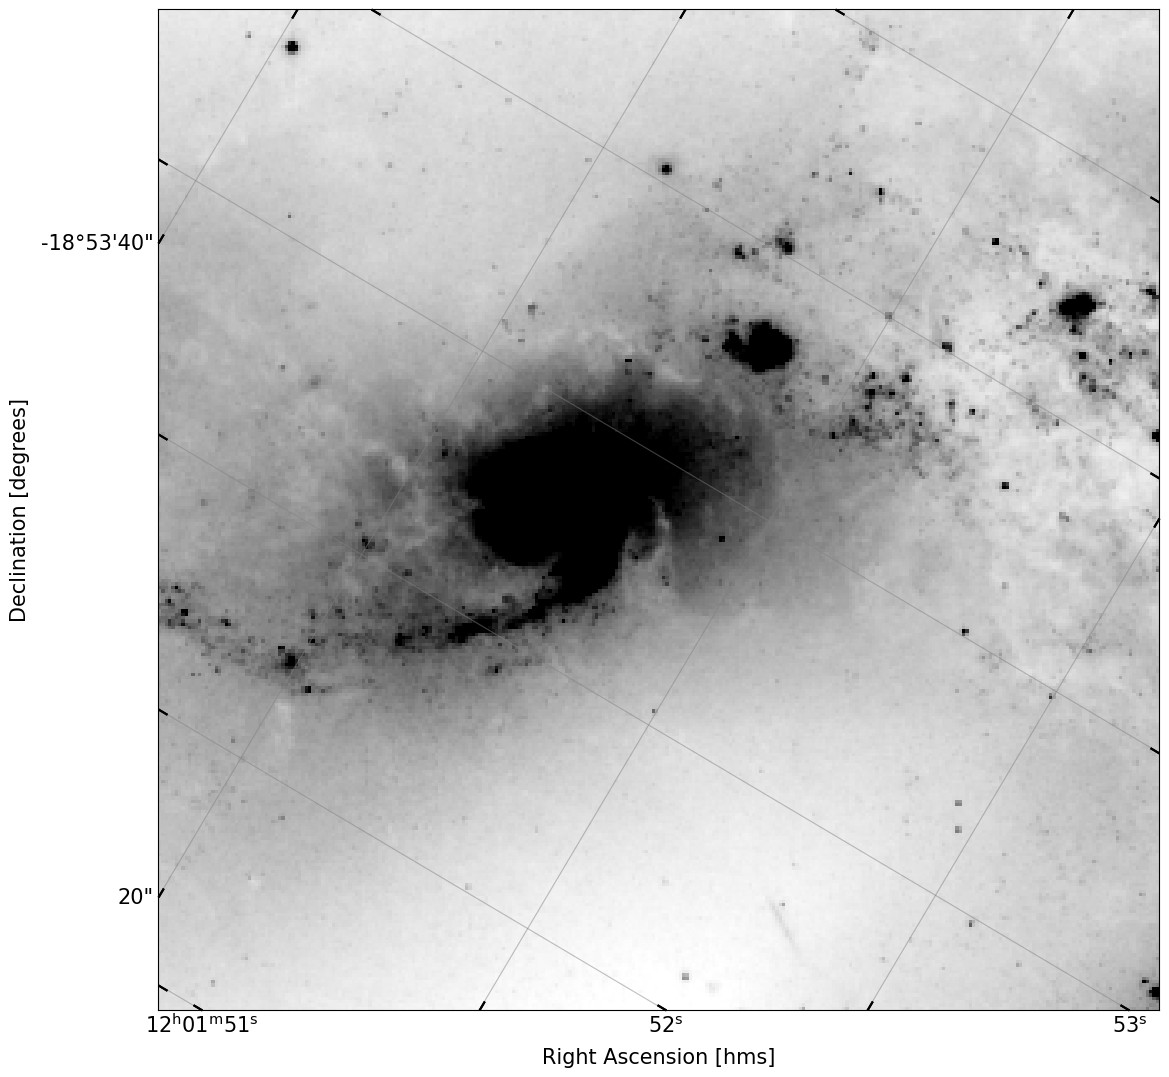

In [237]:
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u

coord = SkyCoord.from_name('NGC 4039')
size = u.Quantity([1,1],u.arcmin)
cutout = Cutout2D(image, coord,size,wcs)
cutout_image = cutout.data

implot(cutout_image,header=new_header,vmin=mu-0.2*sigma,vmax=mu+3*sigma,grid=True,wcs=cutout.wcs)

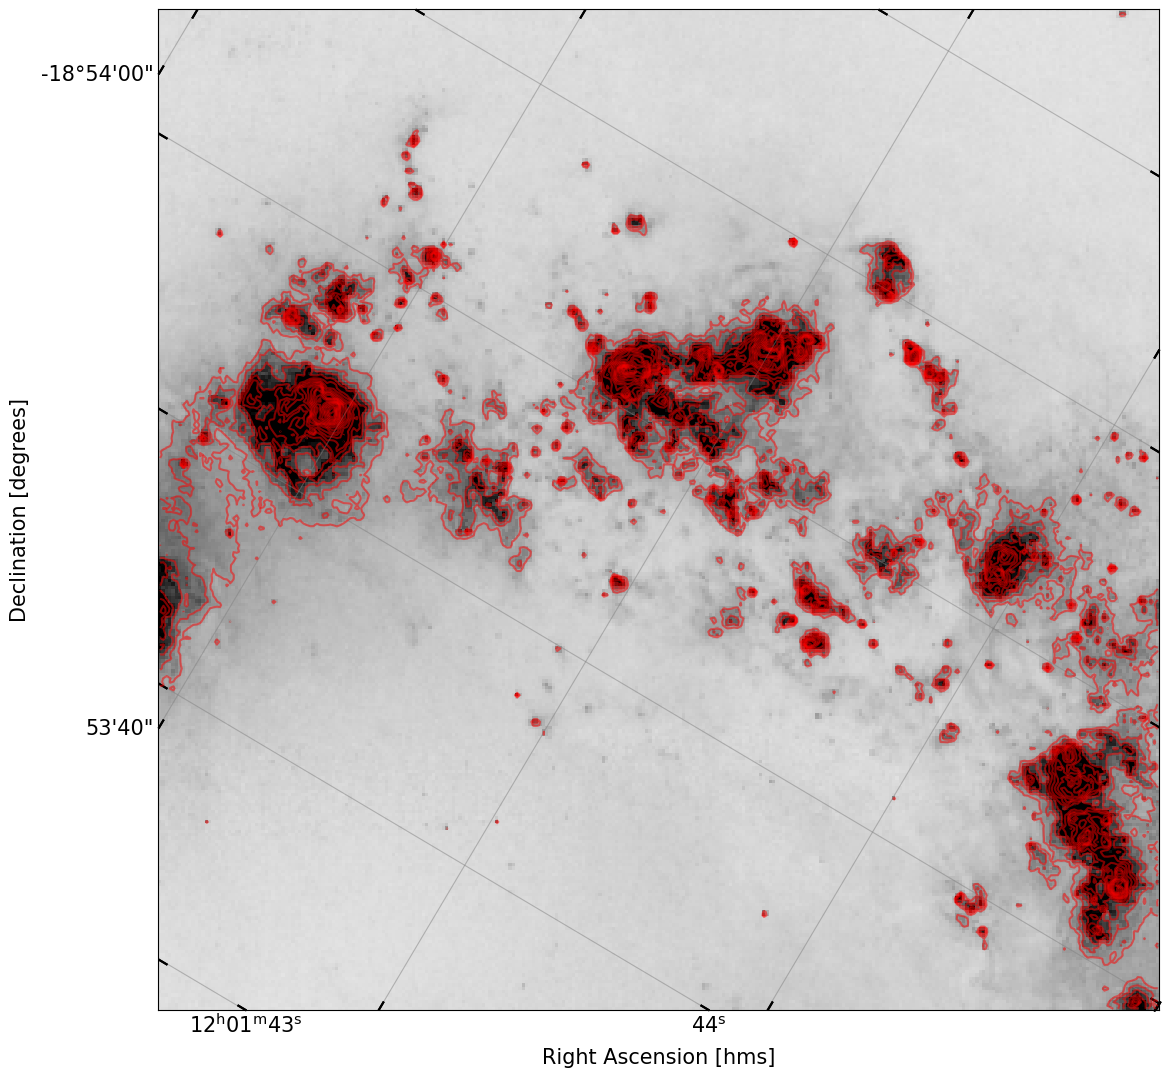

In [272]:
new_coord = SkyCoord('12:01:55.0 -18:52:45',unit=(u.hourangle,u.deg))
size = (1*u.arcmin,1*u.arcmin)
new_cutout = Cutout2D(image,new_coord,size,wcs)
new_cutout_image = new_cutout.data
fig,ax = implot(new_cutout_image,header=new_header,vmin=mu-0.5*sigma,vmax=mu+3*sigma,grid=True)
contours_rband = ax.contour(new_cutout_image,levels=np.logspace(1.8,4,20),colors='r',alpha=0.5)

In [239]:
import sep

def run_sep(data,thresh_scale=2.0):
    '''
    Sep wrapper... runs a basic set of sep commands on a given image
    
    Parameters
    ----------
    data: array_like
        the input image
    thresh_scale: float
        a scaling parameter used by sep to determine when to call something a source (see sep documentation)
        
    Returns
    -------
    objects: numpy struct array
        numpy structured array containing the sep-extracted object locations, etc. 
    '''
    data_corder = data.copy(order='C')
    bkg = sep.Background(data_corder)
    back = bkg.back()
    data_bg_sub = data - back
    c_copy = data_bg_sub.copy(order="C")

    thresh = thresh_scale * bkg.globalrms
    objects = sep.extract(c_copy, thresh)
    return objects


In [225]:
objects = run_sep(new_cutout.data)
len(objects)

103

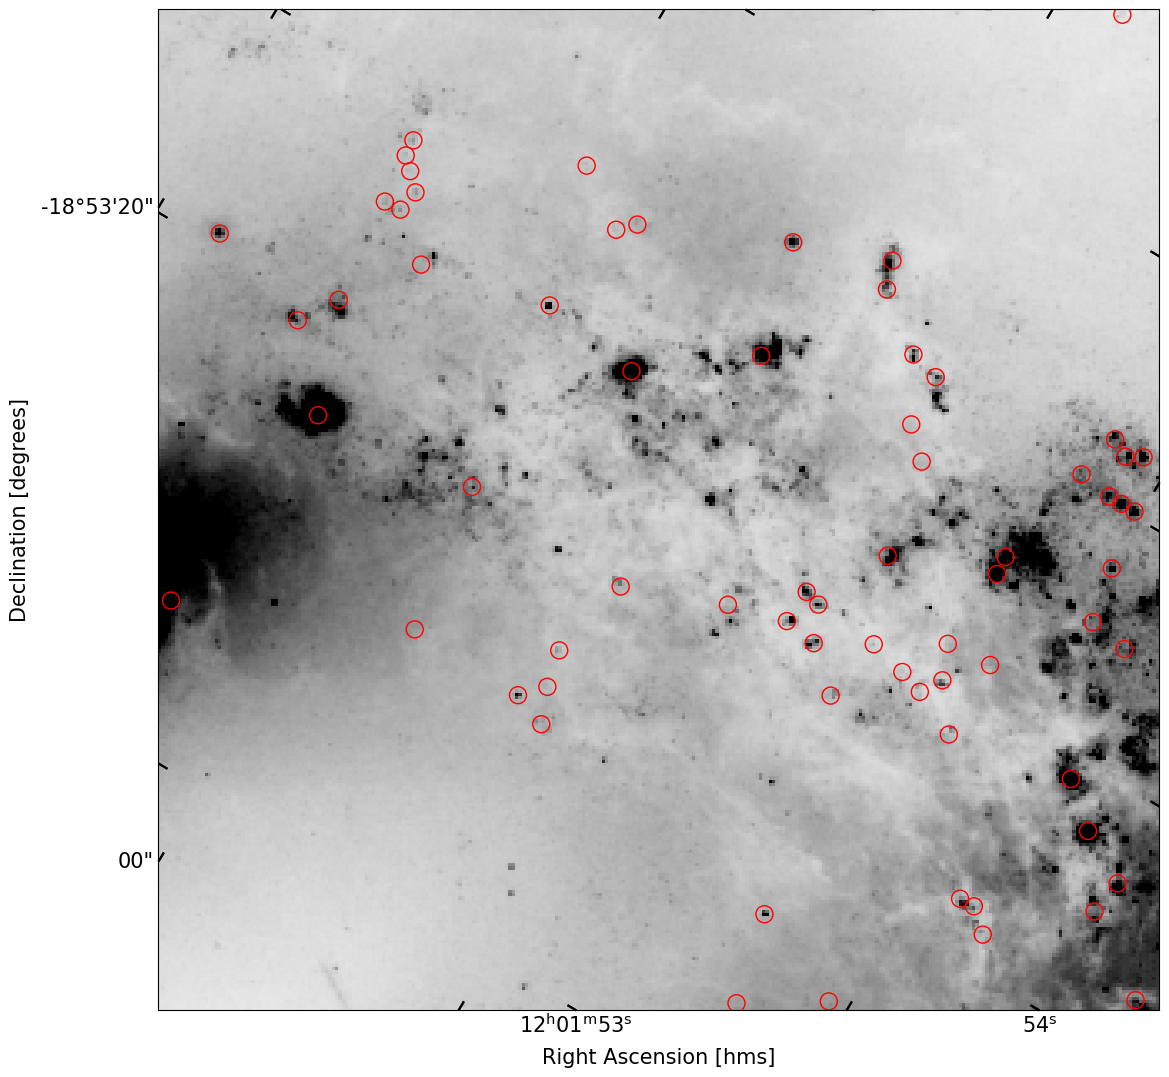

In [240]:
fig,ax = implot(new_cutout_image,wcs=new_cutout.wcs,vmin=mu-0.5*sigma,vmax=mu+3*sigma)
ax.scatter(objects['x'], objects['y'], marker='o', color='none', edgecolors='r', s=150)

In [243]:
import pandas as pd
df = pd.DataFrame(objects)
flux = df.flux
maxim = flux.max()
print(maxim)


428557.5625


In [242]:
def remove_outliers(dataframe,flux_min,flux_max):
    data = dataframe[(dataframe.flux > flux_min) & (dataframe.flux < flux_max)]
    return data

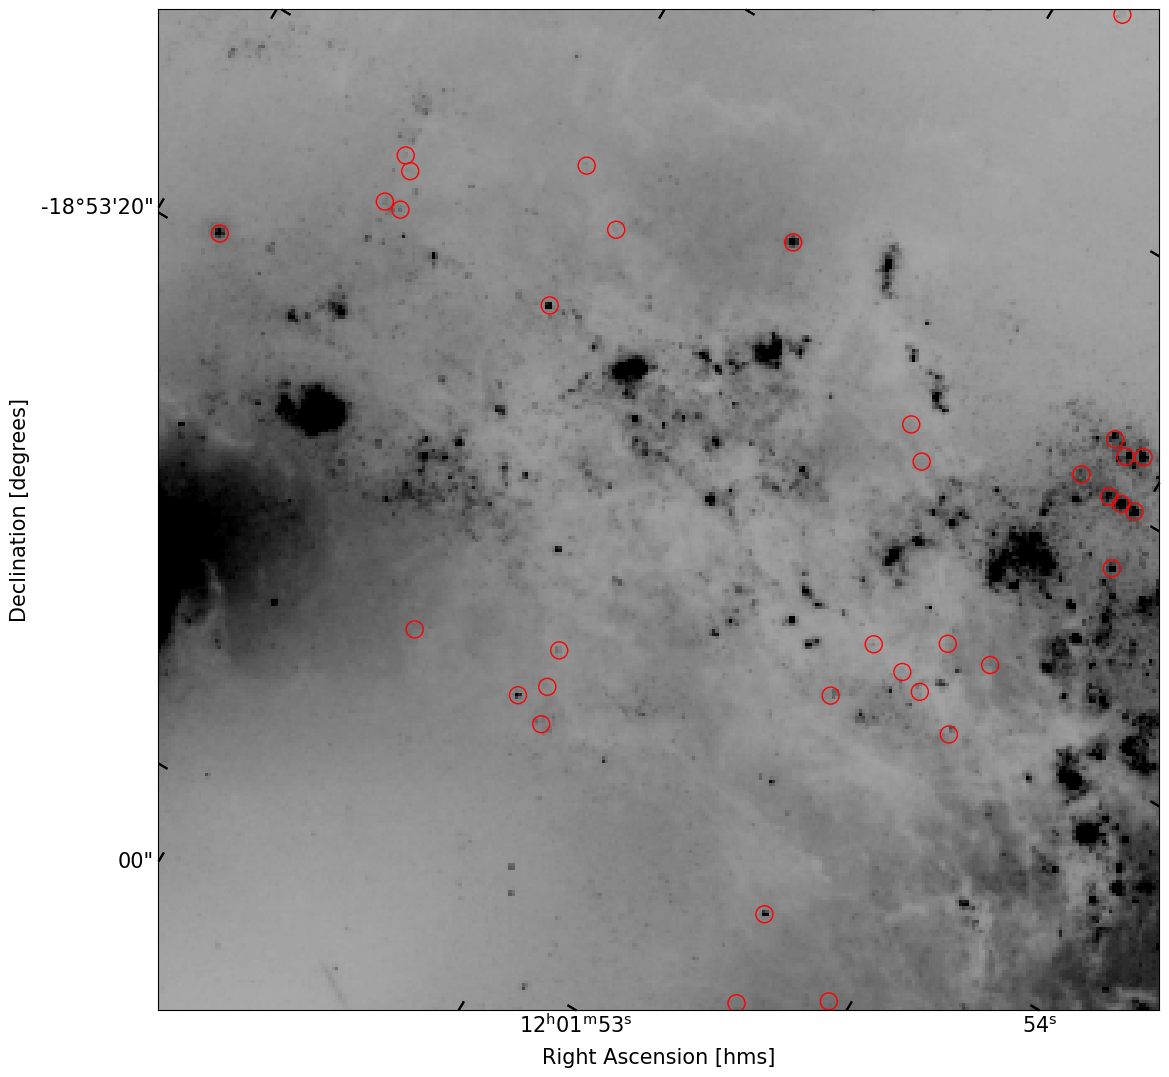

In [250]:
new_data = remove_outliers(df,0,1000)

fig,ax = implot(new_cutout_image,wcs=new_cutout.wcs,scale=2.5)
ax.scatter(new_data['x'],new_data['y'],marker='o',color='none',edgecolors='r', s=150)

#### Problem 4 Continuum Subtraction


In [257]:
header,image = load_fits('antenna_Haband.fits')

header = strip_SIP(header)
wcs = WCS(header)

coordinates = SkyCoord('12:01:55.0 -18:52:45',unit=(u.hourangle,u.deg))
size = (1*u.arcmin,1*u.arcmin)


cutout = Cutout2D(image,coordinates,size,wcs)
cutout_image = cutout.data

objects = run_sep(cutout_image)

dataframe = pd.DataFrame(objects)

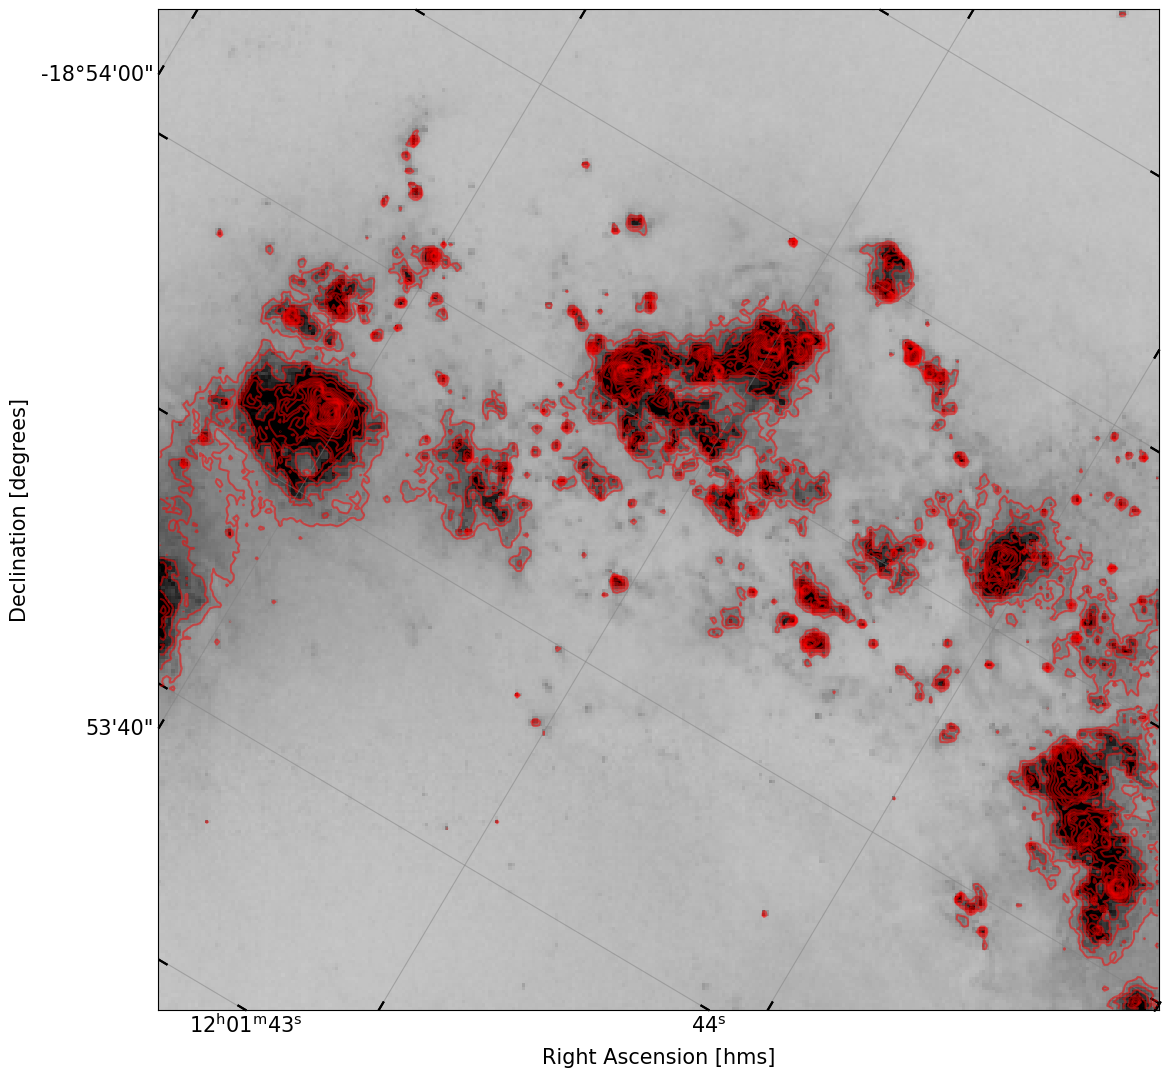

In [273]:
fig,ax = implot(cutout_image,vmin=mu-sigma,vmax=mu+3*sigma,wcs=wcs,grid=True)
contours_ha = ax.contour(cutout_image,levels=np.logspace(1.8,4,20),colors='r',alpha=0.5)

In [275]:
from photutils.aperture import SkyRectangularAperture
from photutils.aperture import aperture_photometry
